In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow import reduce_min,reduce_max,cast,float32
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import mae
from tensorflow.math import less

# An AutoEncoder to detect abnormal Electrocardiograms

In [3]:
dataframe = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv",header = None)
raw_data = dataframe.values

In [4]:
dataframe.head(7)   # Electrocardiogram data

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
5,-1.507674,-3.574550,-4.478011,-4.408275,-3.321242,-2.105171,-1.481048,-1.301362,-0.498240,-0.286928,...,1.089068,0.983369,1.014124,0.952629,0.749326,1.007076,1.634990,1.493366,-0.783134,1.0
6,-0.297161,-2.766635,-4.102185,-4.589669,-4.219357,-3.650443,-2.300518,-1.293917,-1.065658,-0.490520,...,0.581779,0.684406,0.911651,0.979483,1.053458,0.974787,1.110407,1.288165,-0.823386,1.0


In [5]:
len(dataframe)

4998

In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [7]:
labels = raw_data[:,-1]  # labels -> The last column is the label either one or zero.

In [8]:
data = raw_data[:,0:-1] # Input data 0:140 columns

In [9]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,train_size = 0.8,random_state = 21)

In [10]:
""" Normalizing the datapoints """
min_val = reduce_min(train_data)
max_val = reduce_max(train_data)
train_data = (train_data - min_val)/(max_val-min_val)
test_data = (test_data-min_val)/(max_val-min_val)

In [11]:
train_data = cast(train_data,float32)
test_data = cast(test_data,float32)

In [12]:
"""  Sepaarating the normal ECG's from Abnormal ECG's """
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[train_labels] # normal train data corresponds to ECG's with label 1
normal_test_data = test_data[test_labels]
anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]  # anomalous test data corresponds to ECG's with label 0

In [13]:
len(normal_train_data)

2359

Text(0.5, 1.0, 'A normal ECG')

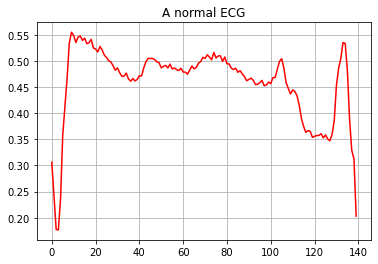

In [14]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[100],color = 'red')
plt.title("A normal ECG")

Text(0.5, 1.0, ' an abnormal ECG')

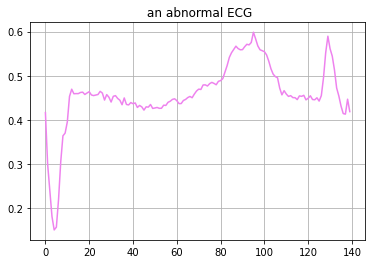

In [15]:
""" anomalaous data points """
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[200],color = "violet")
plt.title(" an abnormal ECG")

In [16]:
""" Encoder and Decoder of S_Net are MLP's"""
""" S_Net(the neural net,the auto encoder)is used to detect anomalous ECGs """
""" The Encoder maps the input input into an 8 dimensional latent space"""

class S_Net(Model):
    def __init__(self):
        super(S_Net,self).__init__()
        self.Encoder = Sequential([
         Dense(32,activation = 'relu'),
         Dense(16,activation = 'relu'),
         Dense(8,activation = 'relu')
        ])
        self.Decoder = Sequential([
        Dense(16,activation = 'relu'),
        Dense(32,activation = 'relu'),
        Dense(140,activation = 'sigmoid')
        ])
        
    def call(self,S):
        encoded = self.Encoder(S)
        decoded = self.Decoder(encoded)
        return decoded

In [17]:
S_NET  = S_Net()

In [18]:
S_NET.compile(optimizer= "adam",loss = 'mae') # mae -> mean absolute error.

In [19]:
""" Training the neural Net."""
hist = S_NET.fit(normal_train_data,normal_train_data,epochs = 30 ,batch_size = 512, 
                   validation_data = (test_data,test_data), shuffle = True)

Epoch 1/30
5/5 [==============================] - 1s 111ms/step - loss: 0.0581 - val_loss: 0.0531
Epoch 2/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0556 - val_loss: 0.0520
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0521 - val_loss: 0.0497
Epoch 4/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0478 - val_loss: 0.0472
Epoch 5/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0433 - val_loss: 0.0445
Epoch 6/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0389 - val_loss: 0.0424
Epoch 7/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0349 - val_loss: 0.0408
Epoch 8/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0320 - val_loss: 0.0397
Epoch 9/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0300 - val_loss: 0.0390
Epoch 10/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0283 - val_loss: 0.0382
Epoch 11/30
5/5 [===========

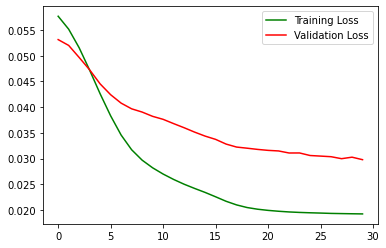

In [20]:
plt.plot(hist.history["loss"],label = "Training Loss",color = "green")
plt.plot(hist.history["val_loss"],label = "Validation Loss",color = "red")
plt.legend()

In [21]:
Encoded_imgs = S_NET.Encoder(normal_test_data).numpy()
Decoded_imgs = S_NET.Decoder(Encoded_imgs).numpy()

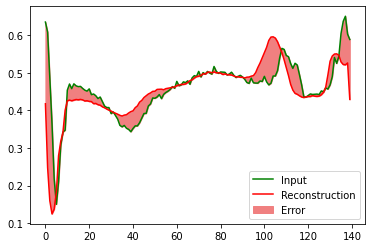

In [22]:
plt.plot(normal_test_data[20],'g')
plt.plot(Decoded_imgs[20],'r')
plt.fill_between(np.arange(140),Decoded_imgs[20],normal_test_data[20],color = 'lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()

In [23]:
Encoded_imgs = S_NET.Encoder(anomalous_test_data).numpy()
Decoded_imgs = S_NET.Decoder(Encoded_imgs).numpy()

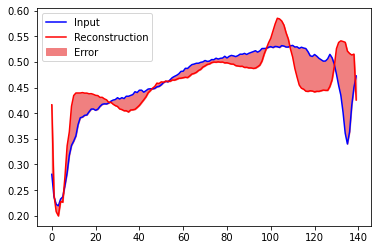

In [24]:
plt.plot(anomalous_test_data[10],'b')
plt.plot(Decoded_imgs[10],'r')
plt.fill_between(np.arange(140), Decoded_imgs[10],anomalous_test_data[10],color = 'lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()

In [23]:
reconstructions = S_NET.predict(normal_train_data)
train_loss = mae(reconstructions,normal_train_data)

In [27]:
"""If the reconstructed error exceeds the threshold value, then It is considered as abnormal"""
threshold = np.mean(train_loss) + np.std(train_loss)

In [28]:
print(threshold)

0.032415718


In [28]:
reconstructions = S_NET.predict(anomalous_test_data)
test_loss = mae(reconstructions,anomalous_test_data)

In [34]:
def predict(model,data,threshold):
    reconstructions = model(data)
    loss = mae(reconstructions,data)
    return less(loss,threshold)

def print_stats(predictions,labels):
    print("Accuracy = {}".format(accuracy_score(labels,preds)))
    print("Precision = {}".format(precision_score(labels,preds)))
    print("Recall = {}".format(recall_score(labels,preds)))

In [38]:
preds = predict(S_NET,test_data,threshold)
print_stats(preds,test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
